# Imports

In [ ]:
from sms_norm import normalize_and_hash_series, dedupe_by_hash
from sms_embed import embed_dedup_dataframe, save_embeddings, load_embeddings
from plots import plot_campaigns
from llm_client import summarize_samples
from persist_utils import save_campaign_footprint

import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
import joblib
import importlib

import os
import numpy as np
import pandas as pd
import joblib
import umap
import umap.umap_ as umap
import hdbscan
from datetime import datetime
from typing import Any, Dict

c:\Users\eliei\Documents\ATT_Campaign_drift\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Stage 1. Reference Profile

## Normalize and embed

In [27]:
# Load the ready-made synthetic data
df_raw = pd.read_csv("./artifacts/synthetic_one_originator.csv")  
#df_raw = pd.read_csv("./artifacts/mixed_160_orig__40_new.csv")  
 

# Normalize + dedupe
norm = normalize_and_hash_series(df_raw["raw_text"], seed=0)
norm.insert(0, "originator_id", df_raw["originator_id"])
norm.insert(1, "message_id", df_raw["message_id"])
dedup_df, _ = dedupe_by_hash(norm)

# Embed (offline MiniLM) and save CSV+NPY
LOCAL_MODEL = r"C:/models/all-MiniLM-L6-v2"  # local model folder

meta_df, X = embed_dedup_dataframe(
    dedup_df, text_col="normalized_text", id_col="template_hash_xx64",
    batch_size=64, normalize=True, model_name=LOCAL_MODEL
)
csv_path, npy_path = save_embeddings(meta_df, X, out_dir="./artifacts", prefix="week_synth")
print("Saved:", csv_path, npy_path)

Saved: ./artifacts\week_synth.csv ./artifacts\week_synth.npy


## UMAP+HDBSCAN, save cetroids + exemplars (LLM for campaign name) 

In [28]:
# --- Cell: build reference, compute centroids, nearest samples, call LLM, persist ---

ART_DIR   = "./artifacts"
PREFIX    = "week_synth"  # from save_embeddings(...)
META_CSV  = os.path.join(ART_DIR, f"{PREFIX}.csv")
VEC_NPY   = os.path.join(ART_DIR, f"{PREFIX}.npy")

assert os.path.exists(META_CSV) and os.path.exists(VEC_NPY), "Run Stage 4 first to create CSV+NPY."

# PARAMETERS
N_NEAREST = 5              # take top K = min(N_NEAREST, cluster_size)
UMAP_PARAMS: Dict[str, Any] = dict(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
    force_approximation_algorithm=False,
    transform_seed=42,
)

HDBSCAN_PARAMS: Dict[str, Any] = dict(
    min_cluster_size=5,
    min_samples=2,
    metric="euclidean",
)

# Load meta + embeddings
meta, X = load_embeddings(out_dir=ART_DIR, prefix=PREFIX, encoding="utf-8")
#meta = pd.read_csv(META_CSV, encoding="utf-8")
#X = np.load(VEC_NPY)  # shape [M, D]

# Safety: ensure unit-norm (cosine-ready)
X = X.astype(np.float32)
X = X / np.maximum(np.linalg.norm(X, axis=1, keepdims=True), 1e-12)

# UMAP to 2D (for visualization only)
umap_model = umap.UMAP(**UMAP_PARAMS)
X_2d = umap_model.fit_transform(X)
joblib.dump(umap_model, os.path.join(ART_DIR, "umap_model.pkl"))

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(**HDBSCAN_PARAMS)
labels = clusterer.fit_predict(X)

# attach labels into meta so saved points include label column
meta = meta.copy()
meta["label"] = labels

unique, counts = np.unique(labels, return_counts=True)
print("Cluster counts:")
for k, v in zip(unique, counts):
    print(f"  C{k:>3}: {v:>5d}")

# Compute centroids and select exemplars (nearest samples)
cluster_labels = sorted([c for c in set(labels) if c != -1])
centroids = []
campaign_rows = []
examples_rows = []  # will hold campaign_examples (one row per exemplar)
for row_idx, cl in enumerate(cluster_labels):
    member_idx = np.where(labels == cl)[0]
    if member_idx.size == 0:
        continue
    # centroid in original embedding space (384-D), unit-norm
    cvec = X[member_idx].mean(axis=0)
    cvec = cvec / (np.linalg.norm(cvec) + 1e-12)
    centroids.append(cvec.astype(np.float32))

    # sims & ordering (cosine because unit-norm)
    sims = X[member_idx] @ cvec
    order = np.argsort(-sims)
    ordered_idx = member_idx[order]

    k = min(N_NEAREST, ordered_idx.size)
    top_idx = ordered_idx[:k]

    # collect exemplars rows
    for rank, global_i in enumerate(top_idx, start=1):
        sim_value = float(sims[order][rank-1])  # matches rank order
        examples_rows.append({
            "campaign_row_index": row_idx,
            "campaign_label": int(cl),
            "rank": int(rank),
            "message_id": meta.iloc[global_i].get("message_id", ""),
            "template_hash_xx64": meta.iloc[global_i].get("template_hash_xx64", ""),
            # Prefer normalized_text (masked). Use raw_text only if you understand privacy/PII.
            "text_sample": meta.iloc[global_i].get("normalized_text", meta.iloc[global_i].get("raw_text", "")),
            "sim_score": sim_value,
            "count_in_window": int(meta.iloc[global_i].get("count_in_window", 1))
        })

    # campaign-level metadata
    proto_count = int(member_idx.size)
    msg_count = int(meta.iloc[member_idx]["count_in_window"].sum()) if "count_in_window" in meta.columns else proto_count
    # date range: try to use timestamp fields if present else use current build date
    if {"window_start", "window_end"}.issubset(meta.columns):
        dr_start = meta.iloc[member_idx]["window_start"].min()
        dr_end = meta.iloc[member_idx]["window_end"].max()
    elif {"timestamp"}.issubset(meta.columns):
        dr_start = meta.iloc[member_idx]["timestamp"].min()
        dr_end = meta.iloc[member_idx]["timestamp"].max()
    else:
        dr_start = dr_end = datetime.utcnow().isoformat()

    campaign_rows.append({
        "row_index": row_idx,                   # index into centroids array
        "cluster_label": int(cl),               # original HDBSCAN label
        "proto_count": proto_count,
        "msg_count": msg_count,
        "date_range_start": dr_start,
        "date_range_end": dr_end,
        "campaign_name": "",                    # filled later by LLM/human
        "status": "Known"
    })

# Stack centroids
if len(centroids) > 0:
    C = np.vstack(centroids)
else:
    C = np.zeros((0, X.shape[1]), dtype=np.float32)

# Call LLM summarizer for each campaign using the nearest samples (deterministic)
campaigns_df = pd.DataFrame(campaign_rows)
examples_df = pd.DataFrame(examples_rows)

# For each campaign_row_index gather sorted samples and call LLM
campaign_names = []
for row in campaigns_df.itertuples(index=False):
    row_idx = int(row.row_index) # type: ignore
    samples = examples_df[examples_df["campaign_row_index"] == row_idx].sort_values("rank")["text_sample"].tolist()
    # Ensure samples are masked/normalized. summarize_samples will double-check.
    if len(samples) == 0:
        summary = ""
        raw_resp = None
    else:
        # Use the llm_client default model (gpt-4o-mini) or specify explicitly
        summary, raw_resp = summarize_samples(samples, max_words=5, model="gpt-4o-mini", temperature=0.0)
    campaign_names.append(summary or "")

campaigns_df["campaign_name"] = campaign_names

# Persist everything using helper (creates campaigns.csv, campaigns.npy, campaign_examples.csv, points.csv)
save_campaign_footprint(
    out_dir=ART_DIR,
    prefix=PREFIX,
    campaigns_df=campaigns_df,
    centroids=C,
    campaign_examples_df=examples_df,
    points_meta=meta,
    points_2d=X_2d, # type: ignore
)

print("Reference build complete. Artifacts saved under:", ART_DIR)


c:\Users\eliei\Documents\ATT_Campaign_drift\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\eliei\Documents\ATT_Campaign_drift\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\eliei\Documents\ATT_Campaign_drift\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\eliei\AppData\Local\Temp\ipykernel_37012\2026625808.py:102: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  dr_start = dr_end = datetime.utcnow().isoformat()


Cluster counts:
  C -1:     3
  C  0:     5
  C  1:     6
  C  2:     6
  C  3:     6
  C  4:    11
Saved artifacts:
 - campaigns_csv: ./artifacts\week_synth_campaigns.csv
 - centroids_npy: ./artifacts\week_synth_campaign_centroids.npy
 - campaign_examples_csv: ./artifacts\week_synth_campaign_examples.csv
 - points_csv: ./artifacts\week_synth_points.csv
Reference build complete. Artifacts saved under: ./artifacts


## Plot UMAP of reference

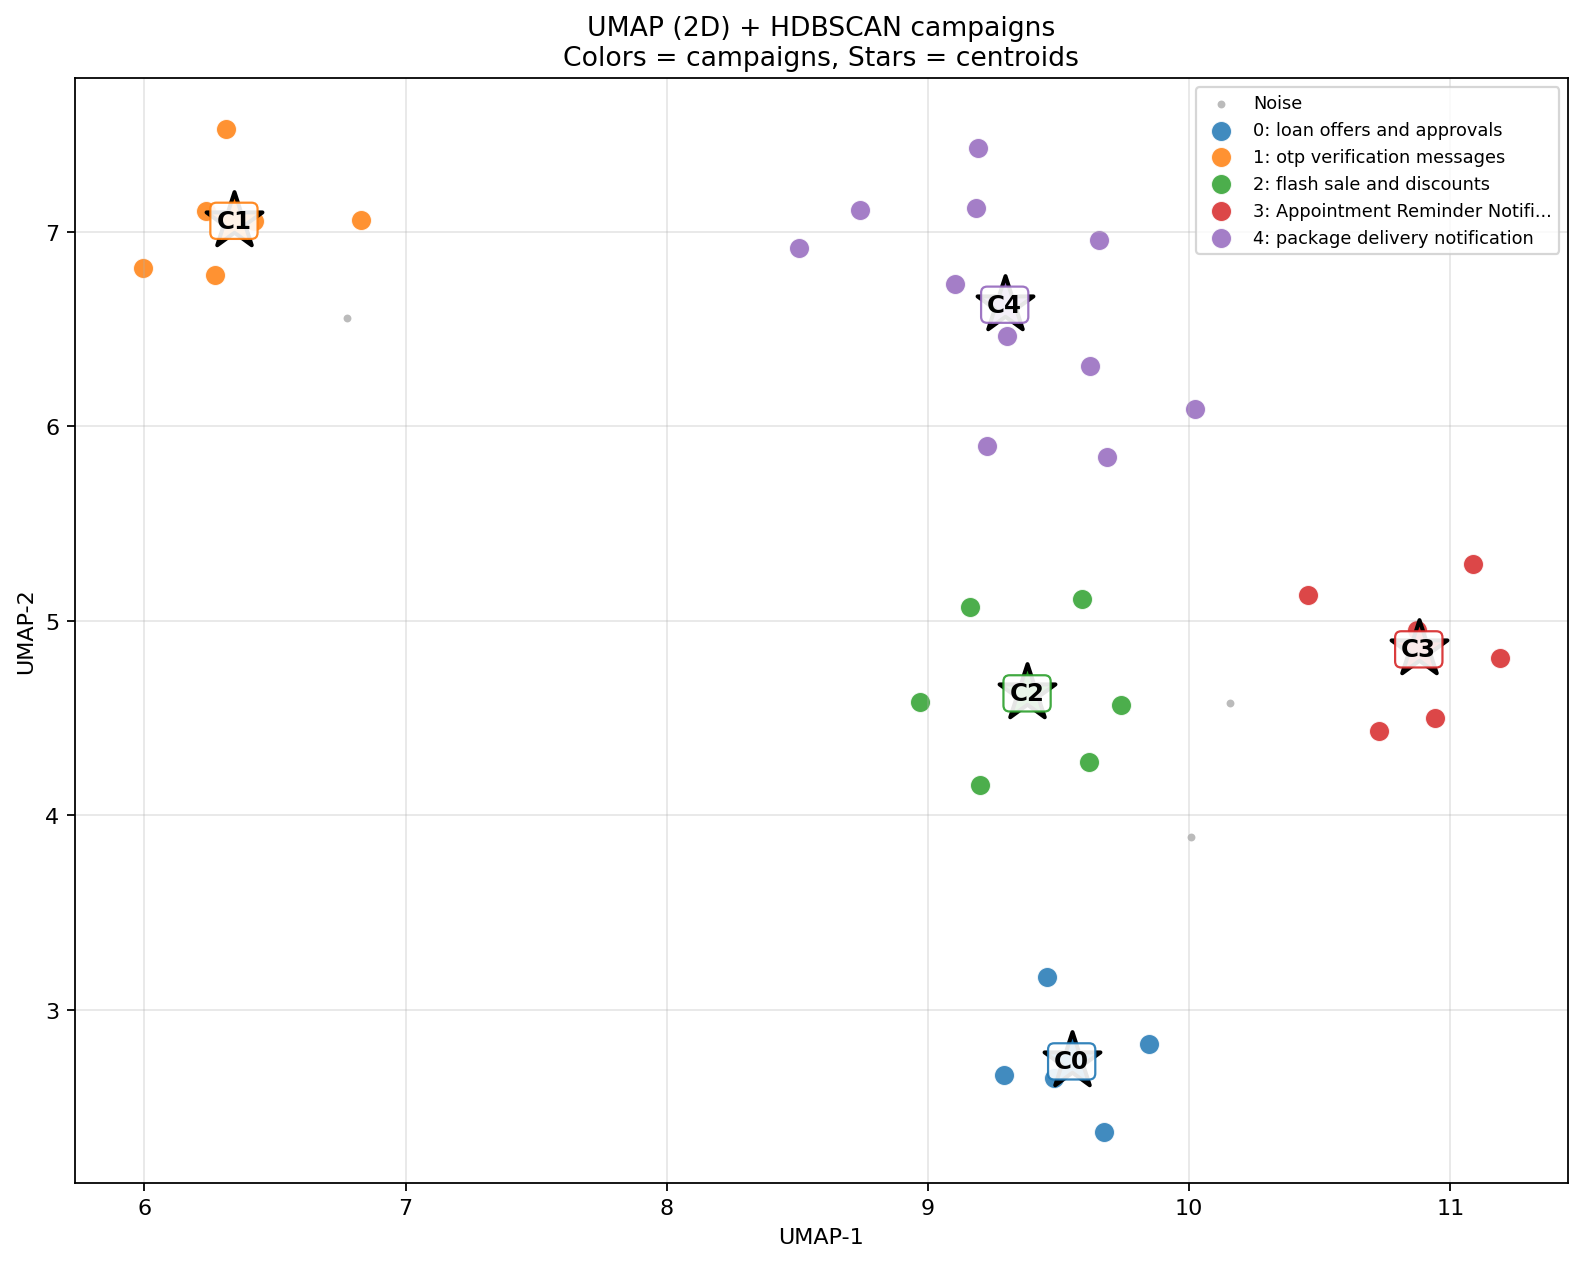

 - plot          : ./artifacts\umap_hdbscan_campaigns.png


In [29]:
plot_path = os.path.join(ART_DIR, "umap_hdbscan_campaigns.png")

# keep the same cluster ID order you use elsewhere (usually row_index order)
cluster_ids = campaigns_df.sort_values("row_index")["cluster_label"].tolist()

# map cluster_id -> LLM campaign_name (fallback to empty string)
campaign_name_map = dict(
    zip(
        campaigns_df["cluster_label"],
        campaigns_df["campaign_name"].fillna("").str.strip()
    )
)

names_list = [campaign_name_map.get(c, "") for c in cluster_ids]

plot_campaigns(X_2d, labels, cluster_ids, plot_path, campaign_names=names_list)
print(" - plot          :", plot_path)


# Stage 2a. New data

In [30]:
# ---------------- Stage 2: assign new batch to saved campaign centroids ----------------

ART_DIR   = "./artifacts"
PREFIX    = "week_synth"
NEW_BATCH = "./artifacts/mixed_160_orig__40_new.csv"  
SIM_THRESHOLD = 0.6  # per SOW

# --- validate artifacts ---
centroids_path = os.path.join(ART_DIR, f"{PREFIX}_campaign_centroids.npy")
campaigns_csv   = os.path.join(ART_DIR, f"{PREFIX}_campaigns.csv")
meta_csv        = os.path.join(ART_DIR, f"{PREFIX}.csv")   # Stage-1 prototypes meta

assert os.path.exists(centroids_path), f"Missing centroids: {centroids_path}"
assert os.path.exists(campaigns_csv), f"Missing campaigns CSV: {campaigns_csv}"
assert os.path.exists(NEW_BATCH), f"Missing new batch: {NEW_BATCH}"
assert os.path.exists(meta_csv), f"Missing reference meta CSV: {meta_csv}"

centroids = np.load(centroids_path).astype(np.float32)  # [K, D]
campaigns_df = pd.read_csv(campaigns_csv)
ref_meta_df  = pd.read_csv(meta_csv, encoding="utf-8")

# normalize centroids for cosine
centroids = centroids / np.maximum(np.linalg.norm(centroids, axis=1, keepdims=True), 1e-12)

# --- load new batch and produce deduplicated prototypes (exactly as Stage-1) ---
df_new = pd.read_csv(NEW_BATCH, encoding="utf-8")

# Choose raw text column (Stage-1 used "raw_text")
if "raw_text" in df_new.columns:
    raw_col = "raw_text"
elif "text" in df_new.columns:
    raw_col = "text"
else:
    raw_col = [c for c in df_new.columns if df_new[c].dtype == object][0]

# Normalize + compute template hashes (identical function used in Stage-1)
norm_df = normalize_and_hash_series(df_new[raw_col].astype(str), seed=0)

# Preserve identifiers if present
if "message_id" in df_new.columns:
    norm_df.insert(0, "message_id", df_new["message_id"].values) # type: ignore
if "originator_id" in df_new.columns and "originator_id" not in norm_df.columns:
    norm_df.insert(0, "originator_id", df_new["originator_id"].values) # type: ignore

# Deduplicate by hash -> dedup_df is prototypes (one row per unique normalized_text)
dedup_df, _ = dedupe_by_hash(norm_df)

# Diagnostics about dedup
n_total_rows = len(df_new)
n_prototypes = len(dedup_df)
print(f"New batch rows = {n_total_rows}; dedup prototypes = {n_prototypes}")

# Also show dedup counts inside the first / last slices (prototype counts)
first_slice_count = dedup_df.iloc[:min(160, n_total_rows)]['normalized_text'].nunique()
last_slice_count  = dedup_df.iloc[min(160, n_total_rows):]['normalized_text'].nunique()
print(f"Dedup prototypes in first slice (<=160 rows): {first_slice_count}")
print(f"Dedup prototypes in last slice (~new campaign): {last_slice_count}")

# --- Embed prototypes only (same function used in Stage-1) ---
# embed_dedup_dataframe returns (meta_df, X) where meta_df contains 'template_hash_xx64' and 'normalized_text'
meta_df, X_proto = embed_dedup_dataframe(
    dedup_df,
    text_col="normalized_text",
    id_col="template_hash_xx64",
    batch_size=64,
    normalize=True
)

# Ensure dtype and normalize
X_proto = np.asarray(X_proto, dtype=np.float32)
X_proto = X_proto / np.maximum(np.linalg.norm(X_proto, axis=1, keepdims=True), 1e-12)

# Save dedup prototype embeddings & meta for traceability (optional)
out_meta_prototypes = os.path.join(ART_DIR, f"{PREFIX}_new_prototypes.csv")
out_npy_prototypes  = os.path.join(ART_DIR, f"{PREFIX}_new_prototypes.npy")
meta_df.to_csv(out_meta_prototypes, index=False, encoding="utf-8")
np.save(out_npy_prototypes, X_proto.astype(np.float32))

# --- Assign prototypes to nearest campaign centroids (prototype-level assignment only) ---
sims_proto = X_proto @ centroids.T     # [P, K]
assigned_proto_idx = np.argmax(sims_proto, axis=1)
assigned_proto_score = np.max(sims_proto, axis=1)
proto_status = np.where(assigned_proto_score >= SIM_THRESHOLD, "Known", "Unknown")

# Attach assignment results to meta_df (prototype-level output)
meta_df["assigned_campaign_row_index"] = assigned_proto_idx
meta_df["assigned_campaign_score"] = assigned_proto_score
meta_df["assigned_campaign_label"] = [campaigns_df.loc[i,"cluster_label"] if (i < len(campaigns_df)) else None for i in assigned_proto_idx]
meta_df["assigned_campaign_name"] = [campaigns_df.loc[i,"campaign_name"] if (i < len(campaigns_df)) else "" for i in assigned_proto_idx]
meta_df["status"] = proto_status

# Save prototype-level assignments 
proto_out_path = os.path.join(ART_DIR, f"{PREFIX}_new_prototypes_assignments.csv")
meta_df.to_csv(proto_out_path, index=False, encoding="utf-8")


New batch rows = 200; dedup prototypes = 44
Dedup prototypes in first slice (<=160 rows): 44
Dedup prototypes in last slice (~new campaign): 0


# Stage 2b. search for new campaign in unknown datapoints

In [34]:
# ---------------- Stage 3: cluster Unknown prototypes, LLM-summarize, propose names ----------------
   # returns (label, raw_resp)
# Files produced by Stage-2 (prototype-only pipeline)
ART_DIR = "./artifacts"
PREFIX = "week_synth"
PROTO_META_CSV = os.path.join(ART_DIR, f"{PREFIX}_new_prototypes_assignments.csv")
PROTO_NPY = os.path.join(ART_DIR, f"{PREFIX}_new_prototypes.npy")

# ---------------- PARAMETERS (tune as needed) ----------------
MIN_COVERAGE = 0.8           # if known_prototypes / total_prototypes < MIN_COVERAGE => try to cluster unknowns
MIN_UNASSIGNED = 5           # minimum number of unknown prototypes to consider clustering
MIN_CLUSTER_MEMBERS = 3      # keep only clusters with at least this many prototypes
HDBSCAN_PARAMS = dict(
    min_cluster_size=5,
    min_samples=2,
    metric="euclidean"       # embeddings are unit-normalized -> euclidean ~ cosine
)
N_SAMPLES = 5               # #samples to pass to LLM (use min(N_SAMPLES, cluster_size))
MAX_WORDS = 5                # max words for LLM summary
CENTROID_SIM_THRESHOLD = 0.6 # when propagating proposed assignment, require sim >= this (keeps them conservative)
OUTPUT_PATH = os.path.join(ART_DIR, f"{PREFIX}_new_prototypes_assignments_upserted.csv")

# ---------------- load prototypes meta + embeddings ----------------
assert os.path.exists(PROTO_META_CSV), f"Missing prototype assignments CSV: {PROTO_META_CSV}"
assert os.path.exists(PROTO_NPY), f"Missing prototype embeddings NPY: {PROTO_NPY}"


meta_df = pd.read_csv(PROTO_META_CSV, encoding="utf-8")
X = np.load(PROTO_NPY).astype(np.float32)

# Ensure shapes line up
assert len(meta_df) == X.shape[0], "meta rows and embeddings rows mismatch"

# Compute coverage (prototype-level)
total_protos = len(meta_df)
known_mask = meta_df["status"].astype(str).str.lower() == "known"
n_known = int(known_mask.sum())
coverage = n_known / total_protos if total_protos > 0 else 0.0

print(f"Total prototypes: {total_protos}, Known: {n_known}, coverage={coverage:.3f}")

# Identify unknown prototypes
unknown_idx = np.where(~known_mask)[0]
n_unknown = len(unknown_idx)
print(f"Unknown prototypes: {n_unknown}")

# Decide whether to cluster unknowns
if coverage >= MIN_COVERAGE:
    print(f"Coverage {coverage:.3f} >= MIN_COVERAGE {MIN_COVERAGE}; skipping HDBSCAN.")
    # still save a copy (no changes)
    meta_df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")
    print("Saved (no-op):", OUTPUT_PATH)
elif n_unknown < MIN_UNASSIGNED:
    print(f"Not enough unknown prototypes (n_unknown={n_unknown} < MIN_UNASSIGNED={MIN_UNASSIGNED}); skipping HDBSCAN.")
    meta_df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")
    print("Saved (no-op):", OUTPUT_PATH)
else:
    print(f"Running HDBSCAN on {n_unknown} unknown prototypes...")
    X_unknown = X[unknown_idx]  # shape [n_unknown, D]

    # HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(**HDBSCAN_PARAMS)  # type: ignore
    labels_unknown = clusterer.fit_predict(X_unknown)   # -1 = noise

    unique_labels, counts = np.unique(labels_unknown, return_counts=True)
    print("HDBSCAN labels:", list(zip(unique_labels.tolist(), counts.tolist())))

    # We'll collect proposed cluster metadata
    proposed_clusters = []
    # Map unknown_idx positions back to meta_df indices
    for lbl in sorted([l for l in unique_labels if l != -1]):
        member_pos = np.where(labels_unknown == lbl)[0]          # positions in X_unknown
        cluster_size = len(member_pos)
        if cluster_size < MIN_CLUSTER_MEMBERS:
            print(f"Skipping cluster {lbl} (size {cluster_size} < MIN_CLUSTER_MEMBERS)")
            continue

        # global indices into meta_df for this cluster
        global_indices = unknown_idx[member_pos]

        # compute centroid in embedding space (mean + unit-normalize)
        centroid = X_unknown[member_pos].mean(axis=0)
        centroid = centroid / np.maximum(np.linalg.norm(centroid), 1e-12)

        # compute similarities of cluster members to centroid
        sims = X_unknown[member_pos] @ centroid
        order = np.argsort(-sims)
        ordered_pos = member_pos[order]           # positions in X_unknown sorted by sim to centroid
        ordered_global_idx = unknown_idx[ordered_pos]  # indices in meta_df

        # pick top samples (min(N_SAMPLES, cluster_size))
        k = min(N_SAMPLES, cluster_size)
        top_globals = ordered_global_idx[:k]
        samples = meta_df.loc[top_globals, "normalized_text"].astype(str).tolist()

        # call LLM to summarize samples (deterministic, max words)
        proposed_label, raw_resp = summarize_samples(samples, max_words=MAX_WORDS, model="gpt-4o-mini", temperature=0.0)

        # store cluster info
        proposed_clusters.append({
            "cluster_label": int(lbl),
            "cluster_size": int(cluster_size),
            "centroid": centroid,
            "proposed_label": proposed_label or "",
            "raw_llm_response": raw_resp,
            "member_global_indices": ordered_global_idx.tolist(),
            "member_sims": sims[order].tolist()
        })

        print(f"Found cluster {lbl} size={cluster_size} proposed_label='{proposed_label}' (top-{k} sent to LLM)")

    # Now propagate proposed labels into meta_df conservatively:
    # For each proposed cluster, for each member compute sim to cluster centroid and,
    # if sim >= CENTROID_SIM_THRESHOLD, set proposed_* fields (keep status='Unknown')
    meta_df = meta_df.copy()
    # initialize proposal columns if missing
    for col in ("proposed_cluster_id", "proposed_campaign_name", "proposed_campaign_score"):
        if col not in meta_df.columns:
            meta_df[col] = "" if "name" in col else pd.NA

    for pc in proposed_clusters:
        centroid = np.asarray(pc["centroid"], dtype=np.float32)
        members = pc["member_global_indices"]
        # compute sims for these members
        member_vecs = X[members]
        sims_to_centroid = member_vecs @ centroid
        for gi, sim_val in zip(members, sims_to_centroid):
            if sim_val >= CENTROID_SIM_THRESHOLD:
                meta_df.at[gi, "proposed_cluster_id"] = int(pc["cluster_label"])
                meta_df.at[gi, "proposed_campaign_name"] = pc["proposed_label"]
                meta_df.at[gi, "proposed_campaign_score"] = float(sim_val)
            else:
                # still fill cluster id but leave name blank if below sim threshold (optional)
                meta_df.at[gi, "proposed_cluster_id"] = int(pc["cluster_label"])
                # do not set proposed_campaign_name if not similar enough
                # but still record the similarity for review
                meta_df.at[gi, "proposed_campaign_score"] = float(sim_val)

    # Save updated prototype assignments for user review. Status remains 'Unknown' until user confirms.
    meta_df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")
    print("Saved updated prototype assignments with proposed clusters to:", OUTPUT_PATH)

    # Print summary of proposed clusters
    if proposed_clusters:
        print("\nProposed clusters summary:")
        for pc in proposed_clusters:
            print(f" - cluster {pc['cluster_label']}: size={pc['cluster_size']}, proposed_label='{pc['proposed_label']}'")
    else:
        print("No new clusters found by HDBSCAN.")

# End Stage-3 cell


Total prototypes: 44, Known: 28, coverage=0.636
Unknown prototypes: 16
Running HDBSCAN on 16 unknown prototypes...
HDBSCAN labels: [(-1, 3), (0, 8), (1, 5)]


c:\Users\eliei\Documents\ATT_Campaign_drift\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\eliei\Documents\ATT_Campaign_drift\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found cluster 0 size=8 proposed_label='mobile boarding pass reminders' (top-5 sent to LLM)
Found cluster 1 size=5 proposed_label='flight updates and notifications' (top-5 sent to LLM)
Saved updated prototype assignments with proposed clusters to: ./artifacts\week_synth_new_prototypes_assignments_upserted.csv

Proposed clusters summary:
 - cluster 0: size=8, proposed_label='mobile boarding pass reminders'
 - cluster 1: size=5, proposed_label='flight updates and notifications'


# debug plot of new data

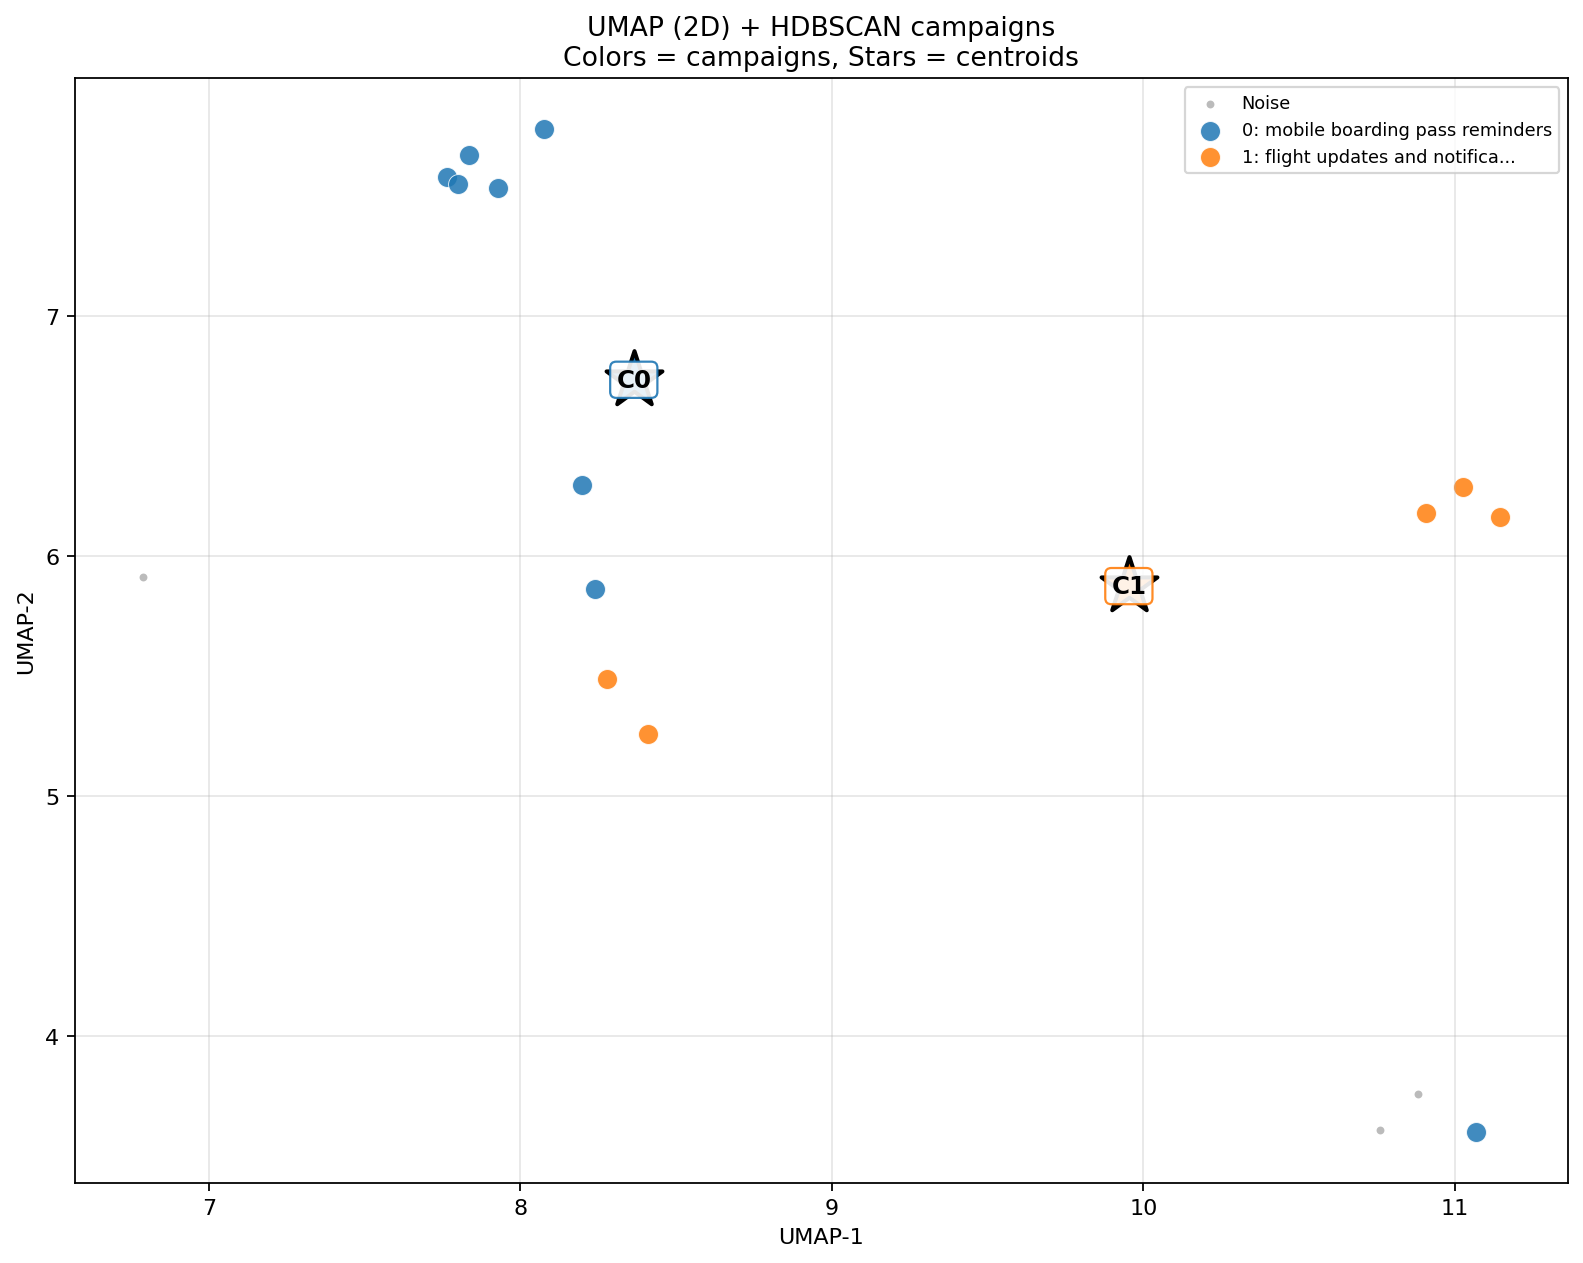

 - plot (unknown): ./artifacts\umap_unknown_campaigns.png


In [ ]:
# 1) 2D coords for the unknown prototypes
umap_model = joblib.load(os.path.join(ART_DIR, "umap_model.pkl"))
X_unknown = X[unknown_idx]  # (n_unknown, D) unit-norm
X_unknown_2d = umap_model.transform(X_unknown)

# 2) Build cluster_ids (exclude -1 noise)
cluster_ids_unknown = sorted([int(l) for l in np.unique(labels_unknown) if l != -1])

# 3) Build campaign-name map from LLM proposals
proposed_name_map = {}
for pc in proposed_clusters:
    proposed_name_map[int(pc["cluster_label"])] = (pc["proposed_label"] or "").strip()

# 4) Plot
unknown_plot_path = os.path.join(ART_DIR, "umap_unknown_campaigns.png")
plot_campaigns(
    X_2d=X_unknown_2d,
    labels=labels_unknown,                  # HDBSCAN labels over unknown subset
    cluster_ids=cluster_ids_unknown,
    save_path=unknown_plot_path,
    campaign_names=proposed_name_map        # legend: "<cluster_id>: <LLM name>"
)
print(" - plot (unknown):", unknown_plot_path)
